In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix
from transformers import (
    RobertaTokenizer, RobertaForSequenceClassification,
    XLNetTokenizer, XLNetForSequenceClassification,
    DebertaV2Tokenizer, DebertaV2ForSequenceClassification
)
from safetensors.torch import load_file
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

2025-06-01 15:11:07.270963: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748790667.480461      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748790667.542414      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
def predict_model(model, dataloader):
    model.eval()
    preds = []

    with torch.inference_mode():
        for batch in tqdm(dataloader, desc=f"Predicting with {model.__class__.__name__}"):
            input_ids, attn_mask, _ = [t.to(device) for t in batch]
            outputs = model(input_ids=input_ids, attention_mask=attn_mask)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=1)[:, 1]
            preds.extend(probs.cpu().numpy())
    return np.array(preds)

In [35]:
def evaluate_on_dataset(test_df, model_tokenizer_dict, batch_size=32, max_length=128):
    df = prepare_df(test_df)
    loaders = {
        name: create_loader(df, tokenizer, batch_size, max_length)
        for name, (_, tokenizer) in model_tokenizer_dict.items()
    }
    
    preds = {}
    for name, (model, _) in model_tokenizer_dict.items():
        pred = predict_model(model, loaders[name])
        preds[name] = pred
    
    # Soft voting
    pred_values = list(preds.values())
    avg_pred = sum(pred_values) / len(pred_values)
    final = (avg_pred >= 0.5).astype(int)
    y_true = df['Label'].values
    
    # Sample df
    sample_df = pd.DataFrame({
        'Tweet': df['Text'].iloc[:5].values,
        'Actual_Label': y_true[:5],
        'XLNet_Prob': preds['xlnet'][:5] if 'xlnet' in preds else [0]*5,
        'RoBERTa_Prob': preds['roberta'][:5] if 'roberta' in preds else [0]*5,
        'DeBERTa_Prob': preds['deberta'][:5] if 'deberta' in preds else [0]*5,
        'Avg_Prob': avg_pred[:5],
        'Predicted_Label': final[:5]
    })
    
    print("\n" + "="*80)
    print("SAMPLE PREDICTIONS for first 5 samples:")
    print("="*80)
    
    for idx, row in sample_df.iterrows():
        print(f"\nSample {idx+1}:")
        print(f"Tweet: {row['Tweet'][:100]}..." if len(row['Tweet']) > 100 else f"Tweet: {row['Tweet']}")
        print(f"Actual Label: {row['Actual_Label']} ({'real' if row['Actual_Label'] == 0 else 'fake'})")
        print(f"XLNet Prob:   {row['XLNet_Prob']:.4f}")
        print(f"RoBERTa Prob: {row['RoBERTa_Prob']:.4f}")
        print(f"DeBERTa Prob: {row['DeBERTa_Prob']:.4f}")
        print(f"Avg Prob:     {row['Avg_Prob']:.4f}")
        print(f"Predicted:    {row['Predicted_Label']} ({'real' if row['Predicted_Label'] == 0 else 'fake'})")
        print("-" * 50)

    print(classification_report(y_true, final, target_names=["real", "fake"], digits=4))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, final)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", 
                xticklabels=["real", "fake"], yticklabels=["real", "fake"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

xlnet = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=2).to(device)
xlnet_tokenizer = XLNetTokenizer.from_pretrained("xlnet-base-cased", do_lower_case=False)
xlnet.load_state_dict(torch.load("/kaggle/input/combined-b/pytorch/default/1/models/XLNet_Combined.ckpt", map_location=device))

roberta = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2).to(device)
roberta_tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
state_dict = load_file("/kaggle/input/roberta-combined/pytorch/default/1/roberta_train_combined/Unified_checkpoint/model.safetensors")
roberta.load_state_dict(state_dict)

deberta = DebertaV2ForSequenceClassification.from_pretrained("microsoft/deberta-v3-base", num_labels=2).to(device)
deberta_tokenizer = DebertaV2Tokenizer.from_pretrained("microsoft/deberta-v3-base")
state_dict = load_file("/kaggle/input/deberta-combined/pytorch/default/1/pool-domain-training/model.safetensors")
deberta.load_state_dict(state_dict)

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/467M [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

<All keys matched successfully>

In [47]:
def prepare_df(df):
    df.columns = df.columns.str.strip()
    
    # text/tweet
    text_col = None
    for col in df.columns:
        if col.lower() in ['tweet', 'text']:
            text_col = col
            break
    
    # label
    label_col = None
    for col in df.columns:
        if col.lower() in ['label', 'class']:
            label_col = col
            break
    
    df_clean = df[[text_col, label_col]].copy()
    df_clean.columns = ['Text', 'Label']
    
    unique_labels = df_clean['Label'].unique()
    
    if set(unique_labels).issubset({'real', 'fake'}):
        df_clean['Label'] = df_clean['Label'].map({'real': 0, 'fake': 1})
        
    return df_clean

def encode_data(df, tokenizer, max_length):
    encodings = tokenizer(
        list(df['Text']),
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors="pt"
    )
    labels = torch.tensor(df['Label'].values)
    return TensorDataset(encodings['input_ids'], encodings['attention_mask'], labels)

def create_loader(df, tokenizer, batch_size, max_length):
    df = prepare_df(df)
    dataset = encode_data(df, tokenizer, max_length)
    return DataLoader(dataset, batch_size=batch_size)

def evaluate_multiple_datasets(test_paths, model_tokenizer_dict):
    for path in test_paths:
        print(f"\n{'='*50}")
        print(f"Evaluating on {path}")
        print(f"{'='*50}")
        try:
            test_df = pd.read_csv(path)
            print(f"Original columns: {test_df.columns.tolist()}")
            print(f"Dataset shape: {test_df.shape}")
            
            test_df_clean = prepare_df(test_df)
            print(f"Successfully prepared dataset with {len(test_df_clean)} samples")
            
            evaluate_on_dataset(test_df_clean, model_tokenizer_dict)
            
        except Exception as e:
            print(f"Error details: {str(e)}")
            print(f"Error type: {type(e).__name__}")
            
            try:
                test_df = pd.read_csv(path)
                print(f"Sample data:")
                print(test_df.head(2))
                print(f"Data types:")
                print(test_df.dtypes)
            except:
                print("Cannot load or display sample data")


Evaluating on /kaggle/input/covid19-fake-news-dataset-nlp/english_test_with_labels.csv
Original columns: ['id', 'tweet', 'label']
Dataset shape: (2140, 3)
Successfully prepared dataset with 2140 samples


Predicting with RobertaForSequenceClassification: 100%|██████████| 67/67 [00:15<00:00,  4.20it/s]
Predicting with DebertaV2ForSequenceClassification: 100%|██████████| 67/67 [00:20<00:00,  3.19it/s]


SAMPLE PREDICTIONS for first 5 samples:

Sample 1:
Tweet: Our daily update is published. States reported 734k tests 39k new cases and 532 deaths. Current hosp...
Actual Label: 0 (real)
XLNet Prob:   0.0002
RoBERTa Prob: 0.0002
DeBERTa Prob: 0.0003
Avg Prob:     0.0002
Predicted:    0 (real)
--------------------------------------------------

Sample 2:
Tweet: Alfalfa is the only cure for COVID-19.
Actual Label: 1 (fake)
XLNet Prob:   0.9998
RoBERTa Prob: 0.9997
DeBERTa Prob: 0.9998
Avg Prob:     0.9998
Predicted:    1 (fake)
--------------------------------------------------

Sample 3:
Tweet: President Trump Asked What He Would Do If He Were To Catch The Coronavirus https://t.co/3MEWhusRZI #...
Actual Label: 1 (fake)
XLNet Prob:   0.9996
RoBERTa Prob: 0.9997
DeBERTa Prob: 0.9997
Avg Prob:     0.9997
Predicted:    1 (fake)
--------------------------------------------------

Sample 4:
Tweet: States reported 630 deaths. We are still seeing a solid national decline. Death reporting lags ap

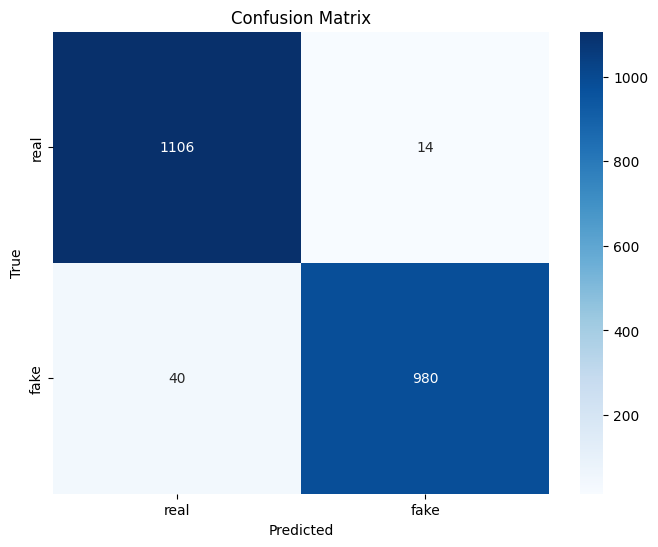


Evaluating on /kaggle/input/ml-20242-g1/gossipcop_test.csv
Original columns: ['id', 'tweet', 'label']
Dataset shape: (3321, 3)
Successfully prepared dataset with 3321 samples


Predicting with RobertaForSequenceClassification: 100%|██████████| 104/104 [00:23<00:00,  4.34it/s]
Predicting with DebertaV2ForSequenceClassification: 100%|██████████| 104/104 [00:31<00:00,  3.27it/s]


SAMPLE PREDICTIONS for first 5 samples:

Sample 1:
Tweet: Grant Gustin & LA Thoma Say They're 'Spirtually Married' Already
Actual Label: 0 (real)
XLNet Prob:   0.2012
RoBERTa Prob: 0.0064
DeBERTa Prob: 0.0083
Avg Prob:     0.0720
Predicted:    0 (real)
--------------------------------------------------

Sample 2:
Tweet: Did Richard Pryor and Marlon Brando hook up? Pryor’s widow says ‘It was the ’70s!’
Actual Label: 0 (real)
XLNet Prob:   0.0705
RoBERTa Prob: 0.0058
DeBERTa Prob: 0.3601
Avg Prob:     0.1455
Predicted:    0 (real)
--------------------------------------------------

Sample 3:
Tweet: Selena Gomez Lovingly Strokes Justin Bieber&#39;s Face on Valentine&#39;s Day
Actual Label: 0 (real)
XLNet Prob:   0.7278
RoBERTa Prob: 0.0256
DeBERTa Prob: 0.0571
Avg Prob:     0.2702
Predicted:    0 (real)
--------------------------------------------------

Sample 4:
Tweet: Giuliana Rancic opens up about life after breast cancer
Actual Label: 0 (real)
XLNet Prob:   0.0323
RoBERTa Prob: 0.00

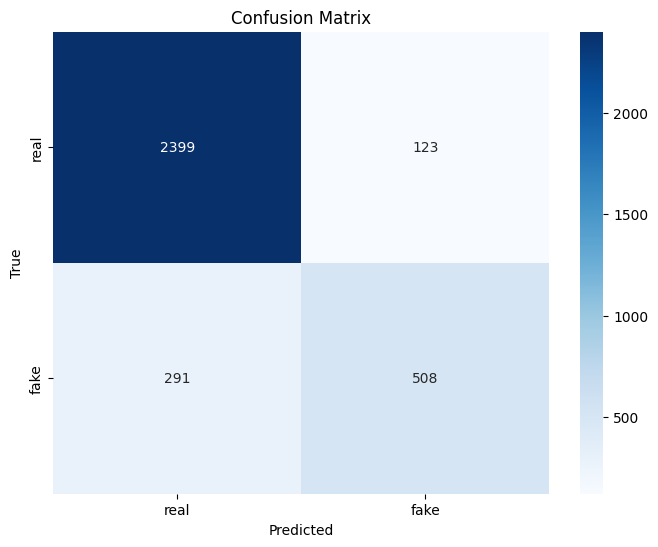


Evaluating on /kaggle/input/ml-20242-g1/liar_test_covid_format.csv
Original columns: ['id', 'tweet', 'label', 'original_label']
Dataset shape: (1267, 4)
Successfully prepared dataset with 1267 samples


Predicting with RobertaForSequenceClassification: 100%|██████████| 40/40 [00:09<00:00,  4.40it/s]
Predicting with DebertaV2ForSequenceClassification: 100%|██████████| 40/40 [00:12<00:00,  3.16it/s]


SAMPLE PREDICTIONS for first 5 samples:

Sample 1:
Tweet: Building a wall on the U.S.-Mexico border will take literally years.
Actual Label: 0 (real)
XLNet Prob:   0.8745
RoBERTa Prob: 0.9971
DeBERTa Prob: 0.4707
Avg Prob:     0.7808
Predicted:    1 (fake)
--------------------------------------------------

Sample 2:
Tweet: Wisconsin is on pace to double the number of layoffs this year.
Actual Label: 1 (fake)
XLNet Prob:   0.7053
RoBERTa Prob: 0.5120
DeBERTa Prob: 0.3215
Avg Prob:     0.5129
Predicted:    1 (fake)
--------------------------------------------------

Sample 3:
Tweet: Says John McCain has done nothing to help the vets.
Actual Label: 1 (fake)
XLNet Prob:   0.9728
RoBERTa Prob: 0.9951
DeBERTa Prob: 0.9965
Avg Prob:     0.9881
Predicted:    1 (fake)
--------------------------------------------------

Sample 4:
Tweet: Suzanne Bonamici supports a plan that will cut choice for Medicare Advantage seniors.
Actual Label: 1 (fake)
XLNet Prob:   0.9973
RoBERTa Prob: 0.9991
DeBERTa 

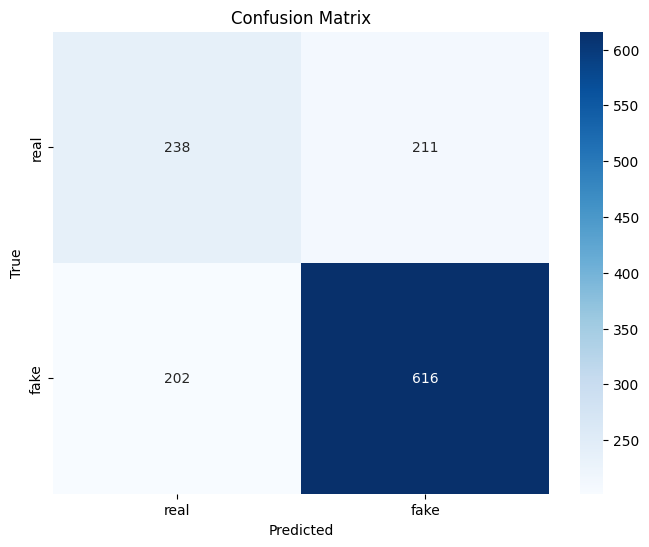


Evaluating on /kaggle/input/ml-20242-g1/politifact_test.csv
Original columns: ['id', 'tweet', 'label']
Dataset shape: (159, 3)
Successfully prepared dataset with 159 samples


Predicting with RobertaForSequenceClassification: 100%|██████████| 5/5 [00:01<00:00,  4.33it/s]
Predicting with DebertaV2ForSequenceClassification: 100%|██████████| 5/5 [00:01<00:00,  3.16it/s]


SAMPLE PREDICTIONS for first 5 samples:

Sample 1:
Tweet: Testimony on CBO’s Assessment of the Air Force’s Plan to Acquire 100 Boeing Tanker Aircraft
Actual Label: 0 (real)
XLNet Prob:   0.1617
RoBERTa Prob: 0.0367
DeBERTa Prob: 0.0039
Avg Prob:     0.0674
Predicted:    0 (real)
--------------------------------------------------

Sample 2:
Tweet: Romney For President Launches New Television Ad, "Remember"
Actual Label: 0 (real)
XLNet Prob:   0.0337
RoBERTa Prob: 0.0014
DeBERTa Prob: 0.0010
Avg Prob:     0.0120
Predicted:    0 (real)
--------------------------------------------------

Sample 3:
Tweet: 3/8/14 Sen. Rob Portman (R-OH) delivers Weekly GOP Address on American jobs
Actual Label: 0 (real)
XLNet Prob:   0.0059
RoBERTa Prob: 0.0009
DeBERTa Prob: 0.0015
Avg Prob:     0.0028
Predicted:    0 (real)
--------------------------------------------------

Sample 4:
Tweet: FindArticles.com
Actual Label: 0 (real)
XLNet Prob:   0.2226
RoBERTa Prob: 0.9716
DeBERTa Prob: 0.9881
Avg Prob:    

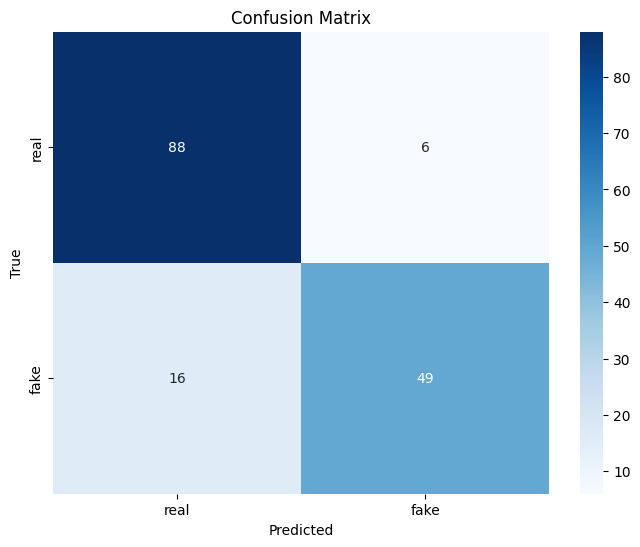

In [48]:
test_paths = [
    "/kaggle/input/covid19-fake-news-dataset-nlp/english_test_with_labels.csv",
    "/kaggle/input/ml-20242-g1/gossipcop_test.csv",
    "/kaggle/input/ml-20242-g1/liar_test_covid_format.csv",
    "/kaggle/input/ml-20242-g1/politifact_test.csv"
]

model_tokenizer_dict = {
    "xlnet": (xlnet, xlnet_tokenizer),
    "roberta": (roberta, roberta_tokenizer),
    "deberta": (deberta, deberta_tokenizer),
}

evaluate_multiple_datasets(test_paths, model_tokenizer_dict)